In [11]:
"""
Gets the halo mass function from the "out_N.list" files.
"""
import numpy as np
import matplotlib.pyplot as plt

total_particle_number = 1.0e8
PMass = 32051887299076.293 / 1.989e33 # Solar masses
Mtot = PMass * total_particle_number # solar masses

def load_halo_out_data(PATH, num):
# loads in the data from "PATH + out_(num).list" to get the halo id list and the number of particles in each
# of the halos. Converts the particle number into a halo mass in solar masses. Returns arrays for the number
# of particles and for the masses of the halos.
    full_halo_data = np.loadtxt(PATH + 'out_' + str(num) + '.list',
                                delimiter=' ', dtype=float, comments='#')
    int_id = full_halo_data[:, 1]
    NPart = full_halo_data[:, 7]
    i = 0
    sub_count = 0
    while i < len(NPart):
        if NPart[i] == 0.0:
            NPart = np.delete(NPart, i)
        else:
            i += 1
        
    HMass = PMass * NPart
    return NPart, HMass;

def make_histogram(array, Nbins):
# histograms the data from "array" into "Nbins" bins spaced evenly in log space
    hist, bins = np.histogram(array, bins=np.logspace(np.log10(np.min(array)),
                            np.log10(np.max(array)),Nbins))
    return hist, bins;

def hmf(hist, bins):
# takes in a histogram and bin locations to make a halo mass function (dn_dlogM or df_dlogM). Calculates the
# errors in these quantities by calculating the error in the number of counts per histogram bin and the 
# propagating to the related quantities
    masses    = np.zeros(np.shape(hist))
    dn_dlogM  = np.zeros(np.shape(hist))
    df_dlogM  = np.zeros(np.shape(hist))
    errors_dn = np.zeros(np.shape(hist))
    errors_df = np.zeros(np.shape(hist))
    
    for i in range(len(hist)):
        # since bins are evenly placed in log space, only need one dlogM
        dlogM = (np.log10(bins[i+1]) - np.log10(bins[i]))
        dn_dlogM[i] = hist[i] / dlogM
        # define the mass locations to be the midpoints between bins
        masses[i] = 0.5 * (bins[i+1] + bins[i])
        df_dlogM[i] = masses[i] * dn_dlogM[i] / Mtot
        errors_dn[i] = np.sqrt(hist[i]) / dlogM
        errors_df[i] = masses[i] * errors_dn[i] / Mtot
    
    return masses, dn_dlogM, errors_dn, df_dlogM, errors_df;

def plot_hmf(PATH, num, z):
    NPart, HMass = load_halo_out_data(PATH, num)
    hist, bins = make_histogram(HMass, 50)
    masses, dn_dlogM, errors_dn, df_dlogM, errors_df = hmf(hist, bins)
    if num == 26:
        plt.errorbar(masses[:], df_dlogM[:], yerr=errors_df[:], fmt='o', capsize=5, label='z = %.1f' % z)
    else:
        plt.errorbar(masses, df_dlogM, yerr=errors_df, fmt='o', capsize=5, label='z = %.1f' % z)
    return;

In [12]:
# get the list of a values output by gadget given the initial a value and the timestep value
a_list = []
a_list.append(0.0001)

a = a_list[0]
while a <= 0.01:
    a_list.append(a * 1.1)
    a = a_list[-1]

Analyzing scale factor: a = 0.0014420993610649957
Analyzing scale factor: a = 0.007289048368510333


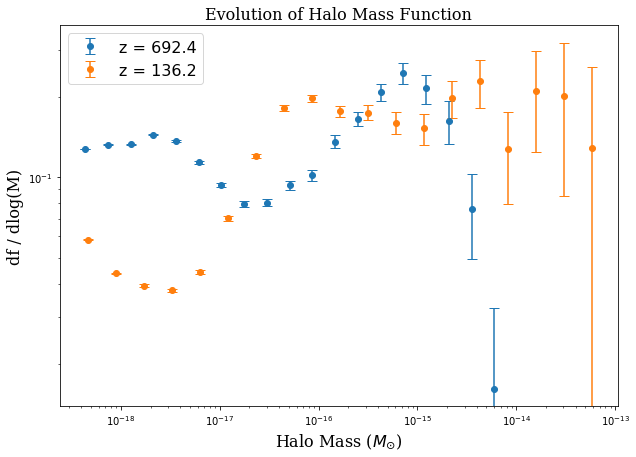

In [14]:
PMass = 32051887299076.293 / 1.989e33
PATH = '/scratch/bsafdi_root/bsafdi/wentmich/halos/'
num_list = [28, 45] # N values for out_N.list files to analyze

plt.figure(figsize=(10, 7))

for i in num_list:
    print('Analyzing scale factor: a = ' + str(a_list[i]))
    NPart, HMass = load_halo_out_data(PATH, i)
    hist, bins = make_histogram(HMass, 20)
    masses, dn_dlogM, errors_dn, df_dlogM, errors_df = hmf(hist, bins)
    plt.errorbar(masses, df_dlogM, yerr=errors_df, fmt='o', capsize=5, label='z = %.01f' % (1 / a_list[i] - 1))
    
plt.yscale('log')
plt.xscale('log')
plt.xlabel(r'Halo Mass ($M_{\odot}$)', fontsize=16, fontname='serif')
plt.ylabel(r'df / dlog(M)', fontsize=16, fontname='serif')
plt.title(r'Evolution of Halo Mass Function', fontsize=16, fontname='serif')
plt.legend(fontsize=16)
plt.savefig('halo_mass_function.png', dpi=1000)
plt.show()